In [1]:
from pathlib import Path
import os, sys
from geopy.geocoders import GoogleV3, Nominatim
import geopandas as gpd
import pandas as pd

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim
from SCanalyzer.busSim.manager import LocalManager
from shapely.geometry import Point
from matplotlib.lines import Line2D

manger init
mangager register
mangager register


In [2]:
%matplotlib inline

In [3]:
DATA_PATH = "../data/transfer_gtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"
START_TIME = "12:58:47"
ELAPSE_TIME = "00:59:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 8
#TRIP_DELAY = [(80000100, "13:20:00"), (80000200, "13:40:00")]
city = gpd.read_file("../data/plot/background/madison-shp")
lakes = gpd.read_file("../data/plot/background/water-shp")
street = gpd.read_file("../data/plot/background/street-shp")
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

sc = SCanalyzer(DATA_PATH)

geolocator = Nominatim(user_agent="wisc_bazarr_demo")
manager = LocalManager(DATA_PATH, OUT_PATH, None)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)#, TRIP_DELAY)

In [4]:
#busSim._gen_final_df(TRIP_DELAY)

In [5]:
cache = {}
def geocode(addr):
    if not "madison" in addr.lower():
        addr += ", Madison WI"
    if not addr in cache:
        cache[addr] = geolocator.geocode(addr)
    return cache[addr]

In [6]:
def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

In [7]:
def plot(starts=[]):      
    ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
    lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
    city.plot(color="black", alpha=0.05, ax=ax, zorder=2)
    street.plot(color="black", alpha=0.03, ax=ax, zorder=3)

    leg_lines = []
    leg_text = []
    
    colors = ["orange", "blue", "green", "yellow"]
    
    zorder = 4
    
    bubbles = []
     
    for i, addr in enumerate(starts):
        print(addr)
        zorder += 10
        location = geocode(addr)
        lat, lon = (location.latitude, location.longitude)
        # check if the point is indeed in Madison
        if lat > max_lat or lat < min_lat or lon > max_lon or lon < min_lon:
            print(lat, lon)
            print(f"Looks like {start} is not in madison.")
            continue
        gdf = busSim.get_gdf(start_point=(lat, lon))
        gdf = gdf.to_crs(epsg=4326)
        
        color = colors[i % len(colors)]
        bubble = flatten(gdf.difference(lakes.unary_union))
        bubble["color"] = color
        bubbles.append(bubble)
        bubble.boundary.plot(color=color, ax=ax, linewidth=2, zorder=zorder+2)
        gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)
        start = gpd.GeoSeries([Point(lon, lat)])
        start.plot(ax = ax, marker='o', color="black", markersize=160, zorder=100)
        
        leg_lines.append(Line2D([0], [0], color=color, lw=4))
        leg_text.append(addr)
        
    df = pd.concat(bubbles)
    df.plot(alpha=0.2, ax=ax, color=df["color"], zorder=zorder)

    leg = ax.legend(leg_lines, leg_text, prop={"size": 18}, loc="upper left")
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_edgecolor("white")

    ax.set_axis_off()
    #print(f'new Stops df {stops_df}')
def demo(addrs_str):
    plot([s.strip() for s in addrs_str.split("\n") if s.strip() != ""])

The Lux
gdf=   stop_id         stop_x         stop_y    radius  \
0        1  598442.406925  734504.194664  570.7275   
1        2  599000.452767  734977.411970  570.7275   
2        3  599631.027712  735514.065020  570.7275   
3        4  600781.288001  736489.167599  570.7275   

                        geometry  
0  POINT (598442.407 734504.195)  
1  POINT (599000.453 734977.412)  
2  POINT (599631.028 735514.065)  
3  POINT (600781.288 736489.168)  


<ipython-input-7-fe091c38a2f6>:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)


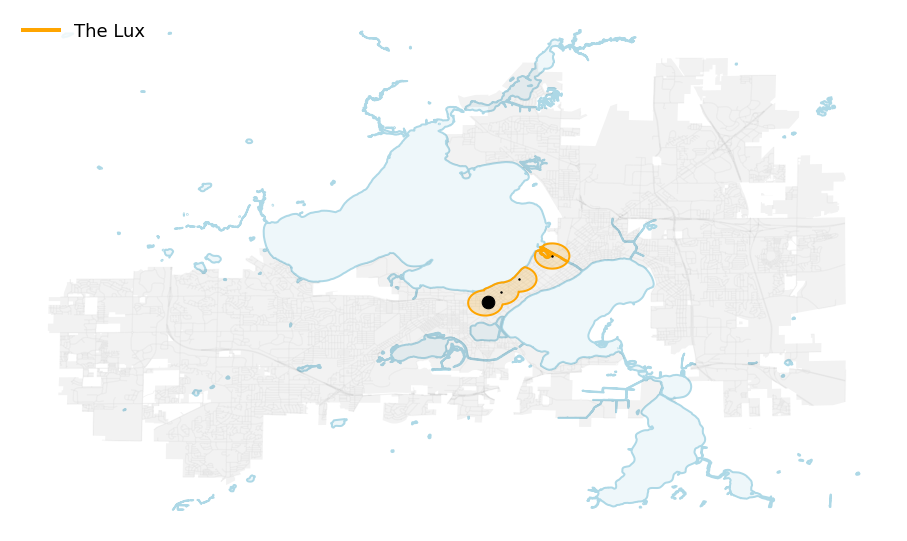

In [8]:
demo("""
The Lux
""")